In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import os

import shutil
from collections import Counter
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

p=10

In [5]:
# Load data
df = pd.read_csv("final_transformed_data_458.csv")
patient_ids = df["patientunitstayid"]
# Create binary target Y
df["Y"] = (df["unitvisitnumber"] ).astype(float)

# Separate features (X) and target (y)
df=df.drop(columns=["patientunitstayid"])
X = df.drop(["unitvisitnumber", "Y"], axis=1)
y = df["Y"].values-1

 

X_test = X
y_test = y

id_test = patient_ids


class SampleSet:
    def __init__(self, index,X, Y,id,module='Bernoulli'):
        """
        Initializes the SampleSet with n samples and p features for X.
        Y is generated based on the conditional probability P(Y=1|X).
        """
        self.index=index
        self.n=X.shape[0]
        self.p=X.shape[1]
        self.X = X
        self.Y = Y
        self.id=id
        self.subtrain=None
        self.subval=None
        self.counts=None
        self.r=int(self.n**index)

    

    def get_sample_set(self):
        """Returns the main sample set (X, Y)."""
        return self.X, self.Y
    
    def get_sub_samples_with_validation(self, B):
        """
        Generates B sub-sample sets, each containing r samples randomly selected 
        from the main sample set, along with corresponding validation sets.
        
        Also counts the number of times each index is selected across all B sub-samples.
        
        Returns:
            train_samples: List of tuples, each containing (train_X, train_Y, train_indices)
            validation_samples: List of tuples, each containing (val_X, val_Y, val_indices)
            selection_counts: Dictionary with counts of each index's appearance in the B sub-samples.
        """
        train_samples = []
        validation_samples = []
        selection_counts = Counter()  # To track appearances of each index
        indices = torch.arange(self.n)
        self.B=B
        for _ in range(B):
            # Randomly select r unique indices for the sub-sample
            selected_indices = indices[torch.randperm(self.n)[:self.r]]
            
            # Update selection count for each index
            selection_counts.update(selected_indices.tolist())
            
            # Get validation indices (those not in selected_indices)
            val_indices = torch.tensor([i for i in indices if i not in selected_indices])

            # Separate sub-sample and validation sets, including original indices
            X_sub = self.X[selected_indices]
            Y_sub = self.Y[selected_indices]
            X_val = self.X[val_indices]
            Y_val = self.Y[val_indices]
            
            # Append to train_samples and validation_samples lists
            train_samples.append((X_sub, Y_sub, selected_indices))
            validation_samples.append((X_val, Y_val, val_indices))
        self.subtrain=train_samples
        self.subval=validation_samples
        self.counts=dict(selection_counts)
        return train_samples, validation_samples, dict(selection_counts)
    
    def save(self, file_path):
        """Saves the SampleSet instance to a file."""
        torch.save(self, file_path)

    @staticmethod
    def load(file_path):
        """Loads a SampleSet instance from a file."""
        return torch.load(file_path,weights_only=False)


# Column indices (0-based)



sample_set = SampleSet(0.9,X_test,y_test,id_test,module='Bernoulli')


In [6]:
### Read the results and combine them into a DataFrame
import os
import torch
import pandas as pd


B=3000
# Define paths
results_folder = 'resultstransfer/'  # Folder where results are stored
sample_set_folder = 'sampleset/transfer/'  # Folder where sample sets are stored

# Initialize an empty DataFrame to store all results
combined_results = pd.DataFrame()
 
results_path = os.path.join(results_folder, f'resultsber{p}NN{B}_folder.pth')
if not os.path.exists(results_path):
    print(f"Results file {results_path} not found. Skipping...")


results = torch.load(results_path)
y_test = results['y_test']  # Ground truth labels for the test set
hatf_B = results['hatf_B']
sd_f = results['sd_f']
sd_f_c = results['sd_f_c']

# Load the corresponding test sample set
test_sample_set_path = os.path.join(sample_set_folder, f'sampleset458{p}bernoulli{B}_testfolder.pth')
if not os.path.exists(test_sample_set_path):
    print(f"Test sample set file {test_sample_set_path} not found. Skipping...")


sample_set_test = sample_set.load(test_sample_set_path)
id_test = sample_set_test.id  # IDs of the test samples
y_testtrue = sample_set_test.Y  # Ground truth labels for the test set

# Combine the data into a DataFrame for the current folder
folder_results = pd.DataFrame({
    'id_test': id_test,
    'y_testtrue': y_testtrue,
    'y_test': y_test,  #Double check, y_test must be the same as y_testtrue
    'hatf_B': hatf_B,
    'sd_f': sd_f,
    'sd_f_c': sd_f_c
})

# Append the folder results to the combined DataFrame
combined_results = pd.concat([combined_results, folder_results], ignore_index=True)

# Save the combined results to a CSV file (optional)
# combined_results.to_csv(f'combined_resultsNN{p}transfer.csv', index=False)
print("Combined results saved to 'combined_results.csv'.")

# Display the combined DataFrame


Combined results saved to 'combined_results.csv'.


In [18]:
combined_results['hatf_B']

0       0.709388
1      -2.331140
2      -2.023852
3      -2.473596
4      -2.369084
          ...   
1075   -2.476920
1076   -2.819906
1077   -2.782793
1078   -2.400606
1079    1.327903
Name: hatf_B, Length: 1080, dtype: float32

tensor([0.7358, 0.6638, 0.5045, 0.5917, 0.4833, 0.7515, 0.6981, 0.7573, 0.7486,
        0.7567, 0.7360, 0.7388, 0.5831, 0.5873, 0.7608, 0.7555, 0.6856, 0.7422,
        0.5811, 0.5769, 0.6709, 0.7197, 0.6029, 0.5976, 0.5458, 0.6902, 0.6491,
        0.7294, 0.6047])
tensor([0.5776, 0.5124, 0.3107, 0.3701, 0.2752, 0.5317, 0.5311, 0.5847, 0.5076,
        0.3745, 0.5914, 0.5341, 0.4127, 0.3531, 0.6010, 0.5081, 0.4735, 0.5034,
        0.3711, 0.3737, 0.4483, 0.5855, 0.4076, 0.3249, 0.3460, 0.5134, 0.4617,
        0.5812, 0.4255])
tensor([0.6612, 0.5903, 0.4038, 0.4799, 0.3734, 0.6495, 0.6181, 0.6770, 0.6367,
        0.5771, 0.6676, 0.6430, 0.4978, 0.4685, 0.6864, 0.6412, 0.5834, 0.6308,
        0.4750, 0.4742, 0.5627, 0.6557, 0.5054, 0.4581, 0.4437, 0.6052, 0.5575,
        0.6592, 0.5156])


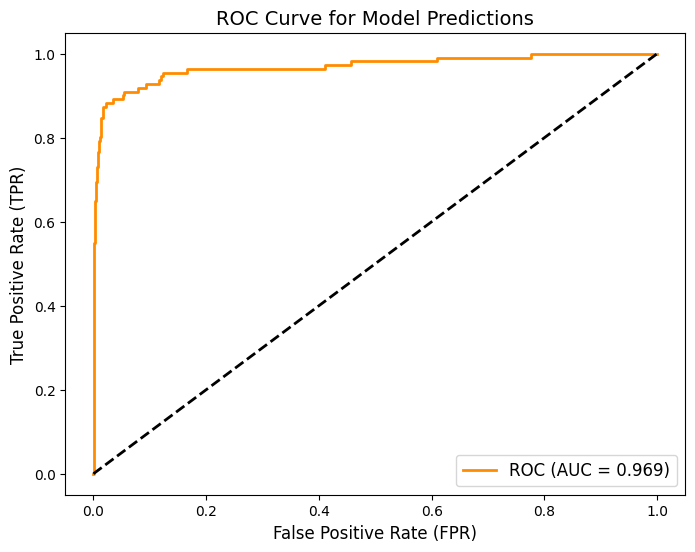

In [7]:
# combined_results= pd.read_csv(f'combined_resultsNN{p}.csv')
#This is the ROC curve
# combined_results = combined_results[combined_results['id_test'] != 989395]

# Convert the filtered data to tensors
hatf_B = torch.tensor(combined_results['hatf_B'].values)
sd_f = torch.tensor(combined_results['sd_f'].values)
sd_f_c = torch.tensor(combined_results['sd_f_c'].values)
y_test = torch.tensor(combined_results['y_test'].values)
id_test = torch.tensor(combined_results['id_test'].values)

# Calculate upper and lower bounds
upper_f = hatf_B + 1.96 * sd_f
lower_f = hatf_B - 1.96 * sd_f
def sigmoid(x):
    return 1/(1+torch.exp(-x))


predicted_probabilities=sigmoid(hatf_B)

indices = torch.nonzero((predicted_probabilities >= 0.3) & (predicted_probabilities <= 0.7)).squeeze()
indices0=torch.nonzero(torch.sigmoid(upper_f)-torch.sigmoid(lower_f)<0.3).squeeze()


print(sigmoid(upper_f[indices])[1:30])
print(sigmoid(lower_f[indices])[1:30])
print(sigmoid(hatf_B[indices])[1:30])




import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert logits (hatf_B) to probabilities using sigmoid
prob_pred = torch.sigmoid(hatf_B).numpy()
y_true = y_test.numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, prob_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate (FPR)',fontsize=12)
plt.ylabel('True Positive Rate (TPR)',fontsize=12)
plt.title('ROC Curve for Model Predictions',fontsize=14)
plt.legend(fontsize=12)
plt.savefig(f'ROClogNN{p}transfer.pdf',bbox_inches='tight')
plt.show()

In [19]:
def compute_tpr_fpr(prob_pred, y_true, threshold=0.5):
    """
    Compute TPR and FPR given predicted probabilities and true binary labels.
    """
    prob_pred = np.array(prob_pred)
    y_true = np.array(y_true)
    
    y_pred = (prob_pred > threshold).astype(int)
    
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # sensitivity / recall
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0  # false positive rate
    
    print(TP,FP,TN,FN)
    return TPR, FPR


compute_tpr_fpr(prob_pred, y_true)

103 225 1953 8


(np.float64(0.9279279279279279), np.float64(0.10330578512396695))

InvalidIndexError: (slice(None, None, None), 1)

In [17]:
prob_pred

y_true

array([0.07747149, 0.5961272 , 0.6612163 , ..., 0.40543345, 0.08190481,
       0.08122222], dtype=float32)

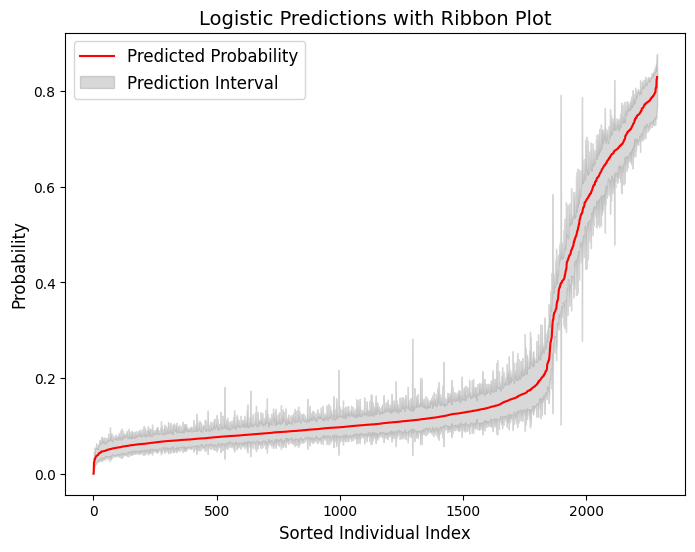

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

lower_p = torch.sigmoid(hatf_B - 1.96 * sd_f_c).numpy()   # Lower bound of the prediction interval
upper_p = torch.sigmoid(hatf_B + 1.96 * sd_f_c).numpy()   # Upper bound of the prediction interval
estimated_prob = torch.sigmoid(hatf_B).numpy()            # Predicted probability
y_true = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Sort individuals by the estimated probability for a smoother ribbon plot
sorted_indices = np.argsort(estimated_prob)
sorted_estimated = estimated_prob[sorted_indices]
sorted_lower = lower_p[sorted_indices]
sorted_upper = upper_p[sorted_indices]
sorted_y = y_true[sorted_indices]
individual_indices = np.arange(len(estimated_prob))

# Plot the ribbon plot
plt.figure(figsize=(8, 6))
plt.plot(individual_indices, sorted_estimated, 'r-', label='Predicted Probability')
plt.fill_between(individual_indices, sorted_lower, sorted_upper, color='gray', alpha=0.3, label='Prediction Interval')
# plt.scatter(individual_indices, sorted_y, color='blue', marker='x', label='Observed y')
plt.xlabel('Sorted Individual Index',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.title('Logistic Predictions with Ribbon Plot',fontsize=14)
plt.legend(loc='upper left',fontsize=12)
plt.savefig(f'individual_logisticNN{p}transfer.pdf',bbox_inches='tight')
plt.show()

2289

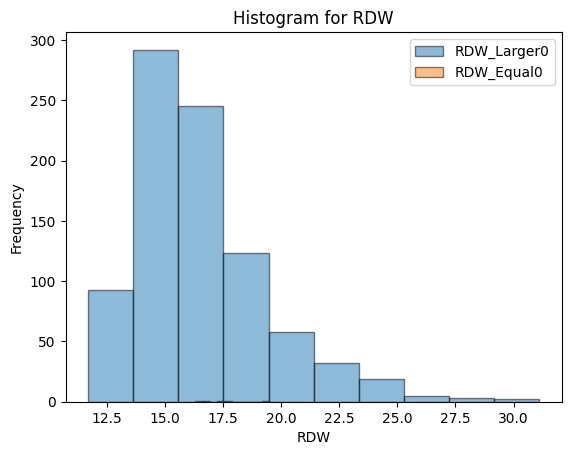

In [6]:
df = pd.read_csv("final_transformed_data.csv")


probabilities = torch.sigmoid(hatf_B)
upper_p=torch.sigmoid(upper_f)
lower_p=torch.sigmoid(lower_f)
# Create a boolean mask, converting the torch tensor to a NumPy array
# mask = (probabilities<0.05).detach().cpu().numpy()

# mask = (((torch.min(upper_p,torch.tensor(0.2))-lower_p)/(upper_p-lower_p))>0.5).detach().cpu().numpy()
# mask = (upper_p<0.2).detach().cpu().numpy()
mask=((upper_p-lower_p)>0.7).detach().cpu().numpy()
# Use the boolean mask directly to index id_test
index = id_test[mask].detach().cpu().numpy()

# selected_df_small = df[(df['patientunitstayid'].isin(index))&(df['unitvisitnumber']==1)&(df['gender_Female']==0)]
selected_df_small = df[(df['patientunitstayid'].isin(index))]






# mask = (((upper_p-torch.max(lower_p,torch.tensor(0.8)))/(upper_p-lower_p))>0.5).detach().cpu().numpy()
mask = (lower_p>0.5).detach().cpu().numpy()
# Use the boolean mask directly to index id_test
index = id_test[mask].detach().cpu().numpy()

# selected_df_big = df[(df['patientunitstayid'].isin(index))&(df['unitvisitnumber']>1)&(df['gender_Female']==0)]
selected_df_big = df[(df['patientunitstayid'].isin(index))]


compare_big=selected_df_big['RDW']
compare_small=selected_df_small['RDW']
compare_big=np.array(compare_big)
compare_small=np.array(compare_small)


import matplotlib.pyplot as plt
plt.hist(compare_big, bins=10, alpha=0.5, label='RDW_Larger0', edgecolor='black')
plt.hist(compare_small, bins=10, alpha=0.5, label='RDW_Equal0', edgecolor='black')

plt.legend()

# plt.figure(figsize=(10, 6))
# plt.scatter(age_big, Hgb_big, color='red', alpha=0.7, label='More than one ICU time')
# plt.scatter(age_small, Hgb_small, color='blue', alpha=0.7, label='Only one ICU time')
plt.xlabel('RDW')
plt.ylabel('Frequency')
plt.title('Histogram for RDW')
plt.legend()
# plt.savefig('RDW_poi.pdf',bbox_inches='tight')


plt.show()

In [15]:
df = pd.read_csv("final_transformed_data.csv")


probabilities = torch.sigmoid(hatf_B)
upper_p=torch.sigmoid(upper_f)
lower_p=torch.sigmoid(lower_f)
# Create a boolean mask, converting the torch tensor to a NumPy array
# mask = (probabilities<0.05).detach().cpu().numpy()

# mask = (((torch.min(upper_p,torch.tensor(0.2))-lower_p)/(upper_p-lower_p))>0.5).detach().cpu().numpy()
# mask = (upper_p<0.2).detach().cpu().numpy()
mask=((upper_p-lower_p)>0.7).detach().cpu().numpy()
# Use the boolean mask directly to index id_test
index = id_test[mask].detach().cpu().numpy()

# selected_df_small = df[(df['patientunitstayid'].isin(index))&(df['unitvisitnumber']==1)&(df['gender_Female']==0)]
selected_df_small = df[(df['patientunitstayid'].isin(index))]




continuous_cols = [0] + list(range(7,13 ))+list(range(26,28 ))

categorical_cols=list(range(37, 38))


print([(X_train.columns[continuous_cols])])
X_train.columns[categorical_cols]

# 根据索引从 X_train 取列名
cols_from_xtrain = X_train.columns[continuous_cols].tolist() + X_train.columns[categorical_cols].tolist()

# 选出 selected_df_small 中和这些名字匹配的列
selected_filtered = selected_df_small[[col for col in cols_from_xtrain if col in selected_df_small.columns]]



print(selected_filtered.head())

df['WBC x 1000']

df['glucose'].mean()

df['unitvisitnumber'][283]

NameError: name 'X_train' is not defined

count    2632.000000
mean      133.858663
std        77.146150
min        32.000000
25%        93.000000
50%       113.000000
75%       147.000000
max      1035.000000
Name: glucose, dtype: float64


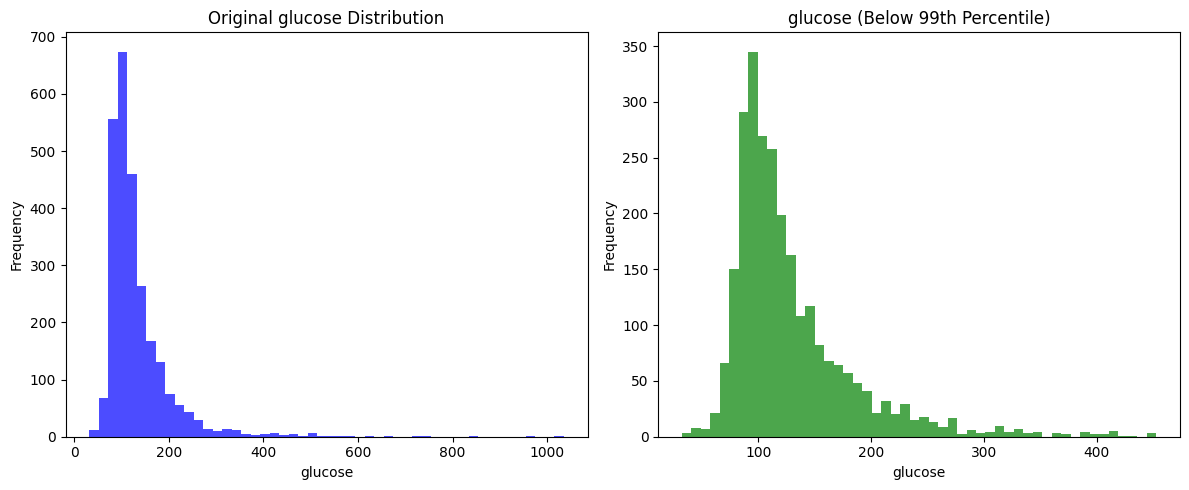

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你已经有 df
# df = pd.read_csv("final_transformed_data.csv")

# column_name = 'WBC x 1000'
column_name = 'glucose'

# 基本描述统计
summary_stats = df[column_name].describe()
print(summary_stats)

# 绘制两个直方图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 原始直方图（包含异常值）
axes[0].hist(df[column_name], bins=50, color='blue', alpha=0.7)
axes[0].set_title(f'Original {column_name} Distribution')
axes[0].set_xlabel(column_name)
axes[0].set_ylabel('Frequency')

# 剔除极端值后的直方图（<99分位）
upper_limit = df[column_name].quantile(0.99)
filtered_data = df[df[column_name] <= upper_limit][column_name]
axes[1].hist(filtered_data, bins=50, color='green', alpha=0.7)
axes[1].set_title(f'{column_name} (Below 99th Percentile)')
axes[1].set_xlabel(column_name)
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 已经加载
# df = pd.read_csv("final_transformed_data.csv")

# 需要处理的两个列
cols = ['glucose', 'WBC x 1000']

# 定义异常值阈值
thresholds = {
    'glucose': 1031,
    'WBC x 1000': 134.3
}

for col in cols:
    plt.figure(figsize=(7, 5))

    # 绘制直方图
    plt.hist(df[col], bins=50, color='skyblue', alpha=0.7)
    plt.title(f'{col} Distribution (with outliers)', fontsize=14)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # 标出异常值位置（红线）
    outlier_values = df[df[col] >= thresholds[col]][col]

    for i, val in enumerate(outlier_values):
        if i == 0:
            plt.axvline(val, color='red', linestyle='dashed', linewidth=1, label='Corresponding Patients')
        else:
            plt.axvline(val, color='red', linestyle='dashed', linewidth=1)

    # Legend
    plt.legend(loc='upper left', fontsize=14)

    # 保存图像
    filename = f"outliers{col.replace(' ', '_')}_distribution.pdf"
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

    print(f"Saved plot: {filename}")

# 输出异常值列表
for col in cols:
    print(f"\nOutliers in {col} (> {thresholds[col]:.2f}):")
    print(df[df[col] > thresholds[col]][[col]])

Saved plot: outliersglucose_distribution.pdf
Saved plot: outliersWBC_x_1000_distribution.pdf

Outliers in glucose (> 1031.00):
      glucose
1967   1035.0
1977   1032.0

Outliers in WBC x 1000 (> 134.30):
      WBC x 1000
283        214.6
466        134.4
1755       187.5
